In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
from download_utils import download_daily_weather, combine_daily_weather
import xarray as xr
import geopandas
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

/Users/jp/miniforge3/envs/id2223/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.15) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [4]:
save = False
plot = True

# Overview
This notebook is run every 3 days. Weather data is downloaded at daily resolution and averaged from the start of the month up to the current day. This is to get a better estimate for the weather variables every 3 days.

# Download weather data

In [5]:
end = pd.Timestamp.today()
start = end.replace(day=1) - relativedelta(months=2) ## -2 months to be able to create lagged features
print("Start of forecast estimate: ", start)
print("End of forecast estimate: ", end)

# start = "2025-04-29"
# end = "2025-05-01"

Start of forecast estimate:  2025-10-01 13:39:15.055011
End of forecast estimate:  2025-12-30 13:39:15.055011


In [6]:
download_daily_weather(start, end)


2025-12-30 13:39:15,379 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-12-30 13:39:15,548 INFO [2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-timeseries?tab=overview)
2025-12-30 13:39:15,549 INFO Request ID is 546fa4a5-9f84-4b39-8e5e-6a8f355530d0
2025-12-30 13:39:15,626 INFO status has been updated to accepted
2025-12-30 13:39:37,185 INFO status has been updated to running
2025-12-30 13:39:48,657 INFO status has been updated to successful


db2f6115c72a22949ec8809dea3d85d2.zip:   0%|          | 0.00/4.23M [00:00<?, ?B/s]

2025-12-30 13:39:52,392 INFO [2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-timeseries?tab=overview)
2025-12-30 13:39:52,393 INFO Request ID is 8f002ddf-842a-47c2-85e9-5d4d97c9e21e



 Downloaded month 10 in 2025


2025-12-30 13:39:52,450 INFO status has been updated to accepted
2025-12-30 13:40:13,688 INFO status has been updated to successful


1f954dc03c69c9a177f92dbe6e393ac3.zip:   0%|          | 0.00/3.94M [00:00<?, ?B/s]

2025-12-30 13:40:16,620 INFO [2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-timeseries?tab=overview)
2025-12-30 13:40:16,621 INFO Request ID is a728ea2b-45e0-4ce6-92b5-924fe60b670e



 Downloaded month 11 in 2025


2025-12-30 13:40:16,910 INFO status has been updated to accepted
2025-12-30 13:40:49,958 INFO status has been updated to successful


8a8030af3a448a4b0f90d849442d0cc6.zip:   0%|          | 0.00/3.04M [00:00<?, ?B/s]


 Downloaded month 12 in 2025


In [7]:
weather_daily = combine_daily_weather()
weather_daily

<xarray.Dataset> Size: 35MB
Dimensions:     (valid_time: 85, latitude: 146, longitude: 141)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 680B 2025-10-01T12:00:00 ... 2025...
  * latitude    (latitude) float64 1kB 69.5 69.4 69.3 69.2 ... 55.2 55.1 55.0
  * longitude   (longitude) float64 1kB 10.5 10.6 10.7 10.8 ... 24.3 24.4 24.5
    expver      (valid_time) <U4 1kB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    t2m         (valid_time, latitude, longitude) float32 7MB nan nan ... 269.0
    tp          (valid_time, latitude, longitude) float32 7MB nan ... 1.736e-05
    swvl1       (valid_time, latitude, longitude) float32 7MB nan nan ... 0.375
    swvl2       (valid_time, latitude, longitude) float32 7MB nan nan ... 0.3835
    ssrd        (valid_time, latitude, longitude) float32 7MB nan ... 1.349e+06
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-30T10:35 GRIB to CDM+CF via cfgrib-0.9.1...

# Prepare dataset for model input

### Average into monthly statistics
This is to transform the data into the same format as our backfill datasets.

In [8]:
weather_agg = weather_daily.resample(valid_time='MS').map(
    lambda x: xr.Dataset({
        "t2m": x["t2m"].mean(dim="valid_time"),
        "tp": x["tp"].sum(dim="valid_time"),
        "swvl1": x["swvl1"].mean(dim="valid_time"),
        "swvl2": x["swvl2"].mean(dim="valid_time"),
        "ssrd": x["ssrd"].sum(dim="valid_time"),
    })
)
weather_agg


<xarray.Dataset> Size: 1MB
Dimensions:     (valid_time: 3, latitude: 146, longitude: 141)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 1kB 69.5 69.4 69.3 69.2 ... 55.2 55.1 55.0
  * longitude   (longitude) float64 1kB 10.5 10.6 10.7 10.8 ... 24.3 24.4 24.5
  * valid_time  (valid_time) datetime64[ns] 24B 2025-10-01 2025-11-01 2025-12-01
Data variables:
    t2m         (valid_time, latitude, longitude) float32 247kB nan ... 276.1
    tp          (valid_time, latitude, longitude) float32 247kB 0.0 ... 0.01528
    swvl1       (valid_time, latitude, longitude) float32 247kB nan ... 0.398
    swvl2       (valid_time, latitude, longitude) float32 247kB nan ... 0.3989
    ssrd        (valid_time, latitude, longitude) float32 247kB 0.0 ... 1.862...

### Create lagged features

In [9]:
# Convert to dataframe for easier manipulation
weather_features = weather_agg.to_dataframe().reset_index()
weather_features = weather_features.sort_values(['latitude', 'longitude', 'valid_time']).reset_index(drop=True)

# Create lagged features for each lat/lon combination
max_lag = 2
weather_vars = ['t2m', 'tp', 'swvl1', 'swvl2', 'ssrd']

# Group by location and create lags
lagged_data = []
for (lat, lon), group in weather_features.groupby(['latitude', 'longitude']):
    group = group.sort_values('valid_time').reset_index(drop=True)
    
    # Lagged features
    for lag in range(1, max_lag + 1):
        for var in weather_vars:
            group[f'{var}_lag{lag+1}'] = group[var].shift(lag)
    
    lagged_data.append(group)

In [10]:
weather_final = pd.concat(lagged_data, ignore_index=True)
weather_final.dropna(inplace=True)
weather_final.drop(columns=['number'], inplace=True)

d = {}
for v in weather_vars:
    d[v] = v+'_lag1'
d['latitude'] = 'Lat'
d['longitude'] = 'Lon'

weather_final.rename(columns=d, inplace=True)
weather_final = weather_final[sorted(list(weather_final.columns))]
weather_final

,Lat,Lon,ssrd_lag1,ssrd_lag2,ssrd_lag3,swvl1_lag1,swvl1_lag2,swvl1_lag3,swvl2_lag1,swvl2_lag2,swvl2_lag3,t2m_lag1,t2m_lag2,t2m_lag3,tp_lag1,tp_lag2,tp_lag3,valid_time
2,55.0,10.5,22439708.0,57946732.0,111332144.0,0.371274,0.364955,0.334737,0.371122,0.358120,0.318441,279.718384,280.878693,285.606628,0.015131,0.023522,0.073831,2025-12-01
5,55.0,10.6,22476206.0,57983484.0,111310336.0,0.371061,0.364825,0.334389,0.370994,0.358065,0.318485,279.705200,280.877899,285.596375,0.015119,0.023587,0.073856,2025-12-01
47,55.0,12.0,24631480.0,60494504.0,119752568.0,0.365779,0.364880,0.338017,0.366316,0.360316,0.324853,279.507782,280.636353,285.318695,0.011303,0.018314,0.056101,2025-12-01
50,55.0,12.1,24712708.0,60590808.0,119974560.0,0.365923,0.365382,0.339502,0.366411,0.360626,0.325493,279.517059,280.640076,285.305481,0.011414,0.018848,0.055625,2025-12-01
56,55.0,12.3,25029008.0,61268528.0,121889248.0,0.243898,0.244547,0.228525,0.246999,0.243248,0.218416,279.605835,280.680176,285.278259,0.010851,0.020913,0.055053,2025-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61745,69.5,24.1,0.0,4534644.0,43640832.0,0.216555,0.239728,0.252815,0.219638,0.245201,0.252953,264.611298,266.006348,275.279633,0.019781,0.016455,0.031202,2025-12-01
61748,69.5,24.2,0.0,4521106.0,43597824.0,0.218185,0.241172,0.252348,0.220296,0.246002,0.252164,264.647919,266.071503,275.341827,0.020088,0.016693,0.031450,2025-12-01
61751,69.5,24.3,0.0,4507432.0,43554632.0,0.219737,0.242586,0.251933,0.220938,0.246811,0.251439,264.685028,266.135895,275.402313,0.020396,0.016932,0.031698,2025-12-01
61754,69.5,24.4,0.0,4489310.0,43511024.0,0.219262,0.242842,0.253278,0.220837,0.247090,0.252991,264.582550,266.097565,275.432983,0.020690,0.017148,0.031927,2025-12-01


In [ ]:
if save: weather_final.to_csv('../data/weather_daily/weather_' + str(end.month) + '_' + str(end.year) + '_.csv', index=False)

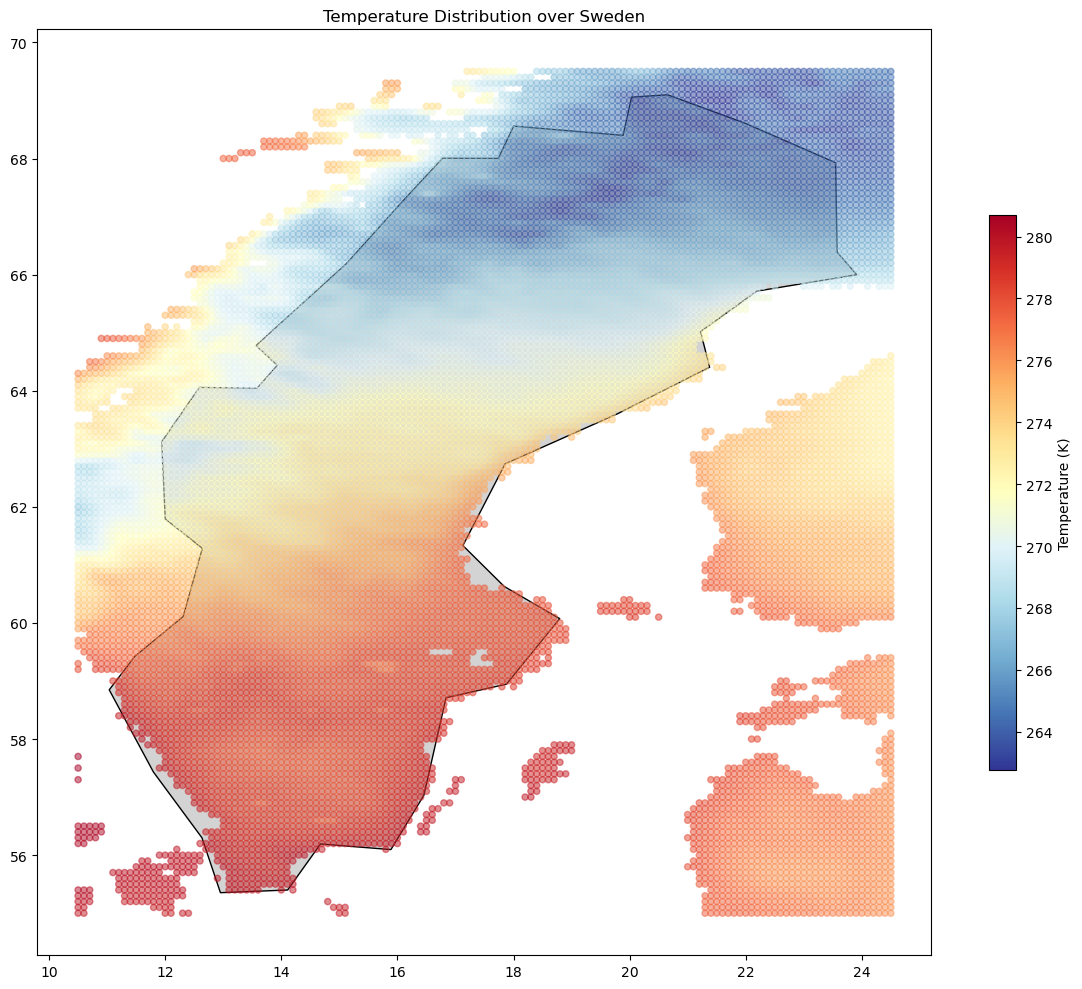

In [14]:
if plot:
    gdf = geopandas.GeoDataFrame(
        weather_final, geometry=geopandas.points_from_xy(weather_final.Lon, weather_final.Lat)
        )

    world = geopandas.read_file('../data/country/ne_110m_admin_0_sovereignty.shp')

    # Plot Sweden with t2m as a heatmap
    ax = world[world['NAME'] == 'Sweden'].plot(
        color='lightgrey', edgecolor='black', figsize=(12, 10))

    # Plot the GeoDataFrame with t2m values as a heatmap
    gdf.plot(ax=ax, column='t2m_lag1', cmap='RdYlBu_r', markersize=20, alpha=0.5, 
            legend=True, legend_kwds={'label': 'Temperature (K)', 'shrink': 0.6})

    ax.set_title('Temperature Distribution over Sweden')
    plt.tight_layout()
    plt.show()